# Content analysis
## Set-up, clean-up

Inspired by: https://github.com/chuachinhon/twitter_state_trolls_cch


In [71]:
# import data
import pandas as pd
en_df = pd.read_csv('data/english_preprocessed.csv')
#zh_df = pd.read_csv('data/chinese_preprocessed.csv')

In [72]:
en_df.head()

,Unnamed: 0,created_at,user,verified,id_str,text,retweet_count,favorite_count,lang,follower_count,hashtags_bytwitter,tokens,text_clean
0,0,2020-05-19 10:59:48,ChinaEUMission,1,1262699470946516992,All parties have reached consensus on a draft ...,0,0,en,14658,NaN,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0...",all parties have reached consensus on a draft ...
1,1,2020-05-19 11:22:28,ChinaEUMission,1,1262705175489363968,China's railway system is expected to reach 14...,0,0,en,14659,NaN,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0...",china s railway system is expected to reach 14...
2,2,2020-05-19 14:09:59,ChinaEUMission,1,1262747333747343366,China has exported over 50 billion masks since...,0,0,en,14665,StrongerTogether,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0...",china has exported over 50 billion masks since...
3,3,2020-05-19 14:34:35,zlj517,1,1262753525655719938,RT @SpokespersonCHN: Not the first time to bas...,0,0,en,621491,NaN,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0...",rt spokespersonchn not the first time to bas...
4,4,2020-05-19 14:34:39,zlj517,1,1262753542101581830,RT @SpokespersonCHN: That what does not kill y...,0,0,en,621491,NaN,"{'n_sent': {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0...",rt spokespersonchn that what does not kill y...


In [73]:
en_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21207 entries, 0 to 21206
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          21207 non-null  int64 
 1   created_at          21207 non-null  object
 2   user                21207 non-null  object
 3   verified            21207 non-null  int64 
 4   id_str              21207 non-null  int64 
 5   text                21207 non-null  object
 6   retweet_count       21207 non-null  int64 
 7   favorite_count      21207 non-null  int64 
 8   lang                21207 non-null  object
 9   follower_count      21207 non-null  int64 
 10  hashtags_bytwitter  15376 non-null  object
 11  tokens              21207 non-null  object
 12  text_clean          21207 non-null  object
dtypes: int64(6), object(7)
memory usage: 2.1+ MB


In [74]:
en_df.user.unique()

array(['ChinaEUMission', 'zlj517', 'globaltimesnews', 'ChinaDaily',
       'SpokespersonCHN', 'euchinahub', 'AmbLiuXiaoMing',
       'ChineseEmbinUK', 'AmbassadeChine', 'ChinaEmbGermany',
       'overseaschina', 'PDChinese'], dtype=object)

In [69]:
# seeing who posts the most
ax = sns.countplot(x="user", data=en_df).set_title('User Distribution')


In [172]:
# setting up matplotlib settings
# Source: https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.font_manager as font_manager

# font
font_dirs = ['/Library/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'DIN Condensed Bold'

# set matplotlib aesthetics
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)

sns.set(rc={
            'axes.axisbelow': False,
            'axes.edgecolor': 'lightgrey',
            'axes.facecolor': 'None',
            'axes.grid': False,
            'axes.labelcolor': 'dimgrey',
            'axes.spines.right': False,
            'axes.spines.top': False,
            'figure.facecolor': 'white',
            'lines.solid_capstyle': 'round',
            'patch.edgecolor': 'w',
            'patch.force_edgecolor': True,
            'text.color': 'dimgrey',
            'xtick.bottom': False,
            'xtick.color': 'dimgrey',
            'xtick.direction': 'out',
            'xtick.top': False,
            'ytick.color': 'dimgrey',
            'ytick.direction': 'out',
            'ytick.left': False,
            'ytick.right': False,
            'savefig.dpi': 800})

#plt.rcParams["savefig.dpi"] = 'figure'
sns.set_context("notebook", rc={"font.size":14,
                                "axes.titlesize":20,
                                "axes.labelsize":18})

## Visualisations
### Frequent terms
#### English

/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/yellowbrick/base.py:259: DeprecationWarning: this method is deprecated, please use show() instead
  "this method is deprecated, please use show() instead", DeprecationWarning


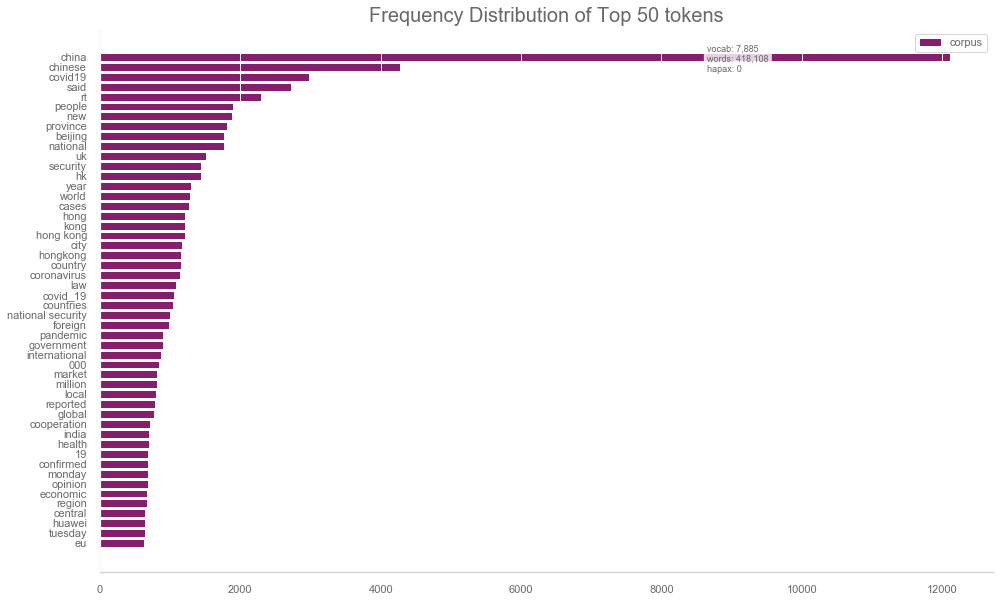

In [174]:
# Visualize frequent terms
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer
from palettable.matplotlib import Inferno_20


# clean text
vect = CountVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(en_df['text_clean'].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features, show = False, color='#84206b')
visualiser.fit(docs)

visualiser.poof('plots/english/top50.png')
#visualiser.poof()

#plt.show()
#plt.savefig('plots/english/top50.png')

#### Chinese

You should consider upgrading via the '/Users/anitakurm/anaconda3/envs/text_to_x/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/yellowbrick/base.py:259: DeprecationWarning: this method is deprecated, please use show() instead
  "this method is deprecated, please use show() instead", DeprecationWarning
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 36817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/anitakurm/anaconda3/envs/text_to_x/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20896 missing fro

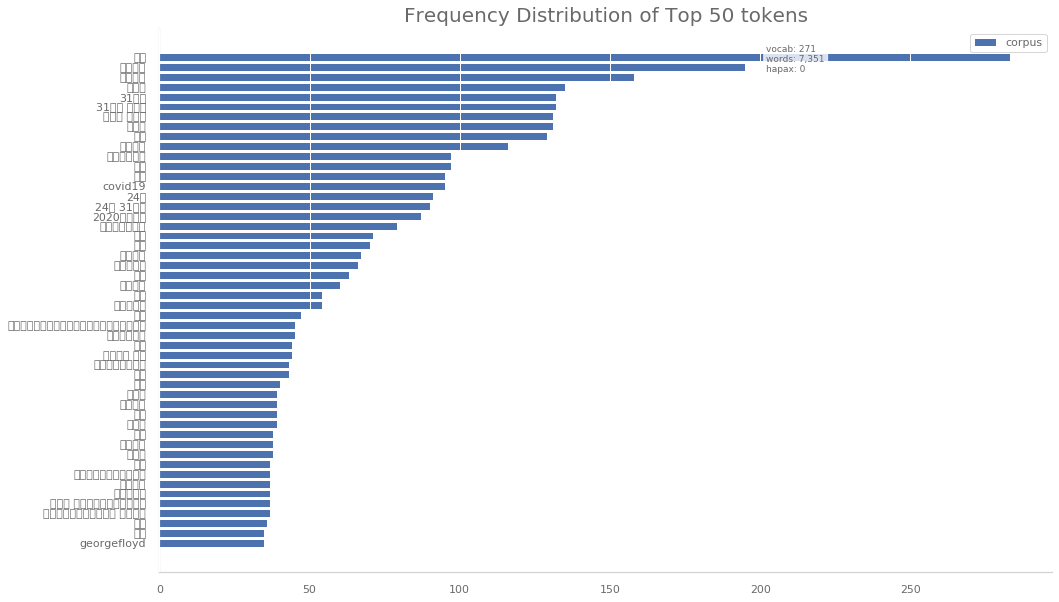

In [46]:
# Visualize frequent terms
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from yellowbrick.text import FreqDistVisualizer, TSNEVisualizer

# change font to chinese
font_dirs = ['/Library/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

plt.rcParams['font.family'] = 'Noto Sans SC'

# clean text
vect = CountVectorizer(min_df=10, ngram_range=(1,2))
docs = vect.fit_transform(zh_df['text_clean'].dropna())
features = vect.get_feature_names()

plt.figure(figsize=(16,10))
visualiser = FreqDistVisualizer(features=features, show = False)
visualiser.fit(docs)

visualiser.poof('plots/chinese/top50.png')

## Topic modelling

### Coherence scores, hyperparameter tuning and evaluation

In [161]:
# csv generated from lda_tuning.py 
coherence = pd.read_csv('lda_tuning_results.csv')
coherence.head()

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.403035
1,75% Corpus,2,0.01,0.31,0.407101
2,75% Corpus,2,0.01,0.61,0.421832
3,75% Corpus,2,0.01,0.9099999999999999,0.366011
4,75% Corpus,2,0.01,symmetric,0.411977


In [163]:
k_scores = coherence.loc[(coherence.Alpha=='0.01') & (coherence.Beta=='0.01')]
k_scores

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,2,0.01,0.01,0.403035
30,75% Corpus,3,0.01,0.01,0.418309
60,75% Corpus,4,0.01,0.01,0.404217
90,75% Corpus,5,0.01,0.01,0.415699
120,75% Corpus,6,0.01,0.01,0.421812
150,75% Corpus,7,0.01,0.01,0.415244
180,75% Corpus,8,0.01,0.01,0.411127
210,75% Corpus,9,0.01,0.01,0.382865
240,75% Corpus,10,0.01,0.01,0.383971
270,75% Corpus,11,0.01,0.01,0.409648


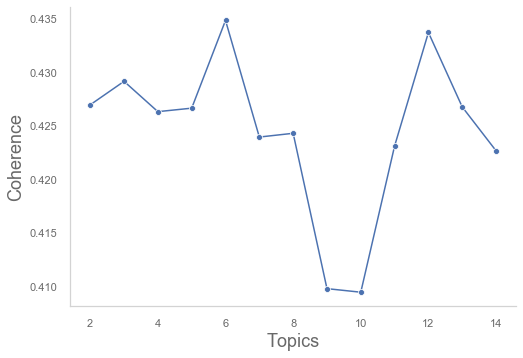

In [170]:
ax = sns.lineplot(x="Topics", y="Coherence", data=k_scores, marker='o', ci = None)

In [173]:
# Save the full figure...
ax.figure.savefig('plots/english/coherence_plot.png')

We can see that coherence is highest with 6 topics. Let's choose alpha and beta parameters based on highest coherence value.

In [165]:
topics_6 = coherence.loc[(coherence.Topics==6)]
topics_6.loc[topics_6['Coherence'].idxmax()]

Validation_Set    100% Corpus
Topics                      6
Alpha                    0.61
Beta                     0.01
Coherence            0.482443
Name: 520, dtype: object

### Best model application

In [10]:
# pyLDAvis
import gensim
import pyLDAvis.gensim
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models, similarities


stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = ' '.join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join([ch for ch in stop_free if ch not in exclude])
    normalized = ' '.join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized


# some additional pre-processing is needed
sample_text = en_df['text_clean']
state_text = list(sample_text.values)

text_clean = [clean(doc).split() for doc in state_text]
dictionary = corpora.Dictionary(text_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_clean]

In [175]:
# I'm keeping the number of topics small so that they would be easier to discern
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix,
               num_topics=6, 
               id2word=dictionary, 
               passes=10,
               alpha=0.61,
               eta=0.01, 
               random_state=3)

In [176]:
tfidf = models.TfidfModel(doc_term_matrix)
doc_tfidf = tfidf[doc_term_matrix]
doc_lda = ldamodel[doc_tfidf]

pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(ldamodel, doc_lda, dictionary, mds='tsne', sort_topics=True)
panel2= pyLDAvis.gensim.prepare(ldamodel, doc_lda, dictionary, mds='tsne', sort_topics=False)

In [177]:
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3       1.465019 -47.625065       1        1  24.224651
2      54.854797 -36.476795       2        1  21.369877
5      32.212929 -61.444572       3        1  13.601366
4       5.111096 -14.110332       4        1  13.601366
1      26.350170 -33.374702       5        1  13.601366
0      38.109818  -7.222781       6        1  13.601366, topic_info=         Term        Freq       Total Category  logprob  loglift
96          u  312.000000  312.000000  Default  30.0000  30.0000
29      china  695.000000  695.000000  Default  29.0000  29.0000
152   covid19  180.000000  180.000000  Default  28.0000  28.0000
185  province  109.000000  109.000000  Default  27.0000  27.0000
563  national  130.000000  130.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
664     south   17.317518   24.009138   Topic6  -5.1154   1.6683
30       city   35.374424   79.843254   Topic6  -4.4011   1.1809
93     people   31.514172  125.639175   Topic6  -4.5166   0.6120
35       high   11.680085   34.842960   Topic6  -5.5092   0.9020
172   central   11.705553   47.933250   Topic6  -5.5070   0.5853

[320 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
24        4  0.817786       000
24        6  0.190817       000
51        4  0.990564         1
1411      4  0.956080        10
827       4  1.050630        11
...     ...       ...       ...
50        5  0.328018      year
50        6  0.093720      year
2311      1  0.985539        yi
760       4  0.991161      yuan
2457      6  1.029926  zhejiang

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 6, 5, 2, 1])

In [178]:
panel2

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0       1.465019 -47.625065       1        1  13.601364
1      54.854797 -36.476795       2        1  13.601364
2      32.212929 -61.444572       3        1  21.369869
3       5.111096 -14.110332       4        1  24.224670
4      26.350170 -33.374702       5        1  13.601364
5      38.109818  -7.222781       6        1  13.601364, topic_info=         Term        Freq       Total Category  logprob  loglift
96          u  312.000000  312.000000  Default  30.0000  30.0000
29      china  695.000000  695.000000  Default  29.0000  29.0000
152   covid19  180.000000  180.000000  Default  28.0000  28.0000
185  province  109.000000  109.000000  Default  27.0000  27.0000
563  national  130.000000  130.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
354  official   16.467234   33.638691   Topic6  -5.1657   1.2807
93     people   22.912066  125.639214   Topic6  -4.8354   0.2932
200   chinese   24.960535  246.301239   Topic6  -4.7498  -0.2943
31    country   20.401247  131.335922   Topic6  -4.9515   0.1328
29      china   19.136856  695.409790   Topic6  -5.0155  -1.5979

[320 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
24        1  0.190817       000
24        5  0.817786       000
51        5  0.990564         1
1411      5  0.956080        10
827       5  1.050630        11
...     ...       ...       ...
50        2  0.328018      year
50        5  0.574032      year
2311      4  0.985538        yi
760       5  0.991161      yuan
2457      1  1.029926  zhejiang

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

In [179]:
#save 
pyLDAvis.save_html(panel2, 'plots/english/6_topics_english.html')

In [180]:
print(panel2.topic_order)
#print(panel2.topic_order)

[1, 2, 3, 4, 5, 6]


#### Word clouds

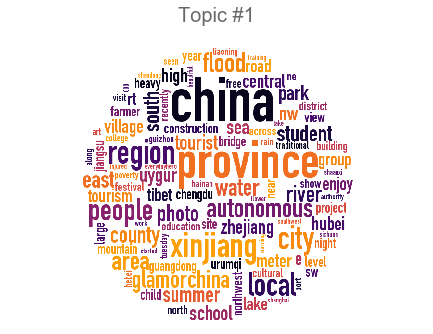

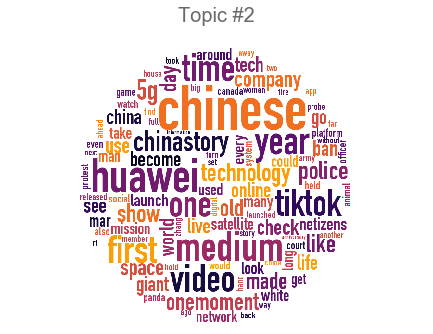

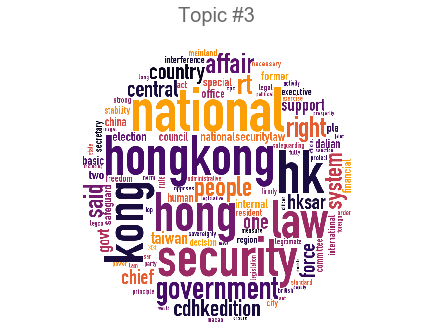

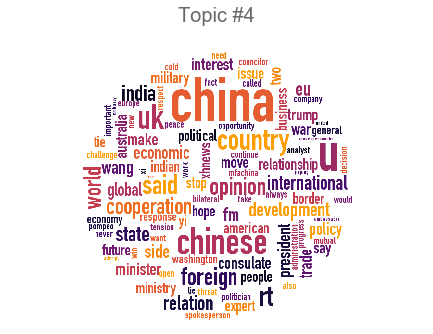

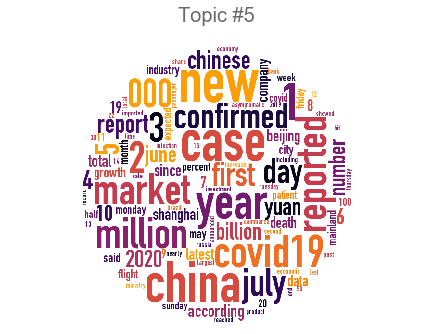

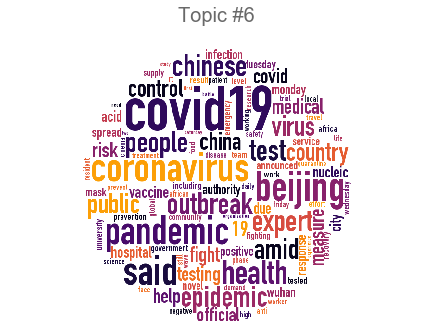

In [187]:
# lda is assumed to be the variable holding the LdaModel object
from wordcloud import WordCloud, STOPWORDS
from palettable.colorbrewer.qualitative import Dark2_8
from palettable.lightbartlein.diverging import BlueDarkOrange18_5
from palettable.matplotlib import Inferno_20
import random
from PIL import Image
import numpy as np

def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Inferno_20.colors[random.randint(1,15)])

font_path = "/Library/Fonts/DIN Condensed Bold.ttf"
icon_path = "utils/circle.png"

mask = np.array(Image.open(icon_path))

for t in range(ldamodel.num_topics):
    plt.figure()
    # wordcloud = WordCloud(background_color="white", max_font_size=60, width=800, height=400)
    wc = WordCloud(font_path=font_path, background_color="white", max_words=100, mask = mask,
                   stopwords=STOPWORDS,
                   max_font_size=130,
                   random_state=42,
                   width=800, height=400)
    plt.imshow(wc.fit_words(dict(ldamodel.show_topic(t, 200))).recolor(color_func=color_func, random_state=3))
    #wc.recolor(color_func=color_func)
    plt.axis("off")
    plt.title("Topic #" + str(t+1))
    #plt.show()
    plt.savefig(f"plots/english/en_wordcloud_topic_{t+1}.png", dpi = 800)
    


### Chinese

See here for word cloud in chinese: https://amueller.github.io/word_cloud/auto_examples/wordcloud_cn.html

## Drafts
### Cluster analysis

NB!! Change to clean text variables; Change HDBScan parameters!

In [ ]:
# general prep
real_clean = en_df['text']
corpus_clean = list(real_clean.values)
tfidf = TfidfVectorizer(stop_words='english', min_df=10, ngram_range=(1,2))
docs_clean = tfidf.fit_transform(corpus_clean)

In [ ]:
# K-Means
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=10)
clusters.fit(docs_clean)
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs_clean, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()
plt.show()


In [ ]:
# HDBScan
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(docs_clean)
plt.figure(figsize=(16,10))
tsne = TSNEVisualizer()
tsne.fit(docs_clean, ["c{}".format(c) for c in clusterer.labels_])
tsne.poof()
plt.show()